# 21. Advanced MARL

## 21.1. Intro
centralized training with decentralized execution (CTDE)
中心化训练去中心化执行

## 21.2. MADDPG
multi-agent DDPG (MADDPG)
多智能体DDPG

基于部分可观测马尔科夫博弈（partial observable Markov Games）：

每个智能体$i$的策略$\pi_{\theta_i}: \mathcal{O}_i \times \mathcal{A}_i \rightarrow [0, 1]$

状态转移函数：$\mathcal{T: S} \times \mathcal{A_1} \times ... \times \mathcal{A_N} \rightarrow \Omega(\mathcal{S})$

每个智能体奖励函数：$r_i : \mathcal{S} \times \mathcal{A} \rightarrow \mathbb{R}$

每个智能体从全局得到的部分观测信息为$\bold{o}_i: \mathcal{S} \rightarrow \mathcal{O}_i$

初始状态分布为$\rho: \mathcal{S} \rightarrow [0, 1]$

每个智能体的目标是最大化其期望累积奖励$\mathbb{E}[\sum_{t=0}^T\gamma^tr_i^t]$

每个智能体期望收益的策略梯度：

$$
\nabla_{\theta_i} J(\theta_i) = \mathbb{E}_{s \sim p^a, a \sim \pi_i}[\nabla_{\theta_i}\log\pi_i(a_i | o_i) Q^\pi_i(\bold{x}, a_1, ..., a_N)]
$$

其中$Q_i^\pi(\bold{x}, a_1, ..., a_N)$: 中心化动作价值函数

DDPG梯度公式
$$
\nabla_{\theta_i} J(\mu_i) = \mathbb{E}_{\bold{x} \sim \mathcal{D}}[\nabla_{\theta_i}\mu_i(o_i) \nabla_{a_i} Q^\mu_i(\bold{x}, a_1, ..., a_N)|_{a_i = \mu_i(o_i)}]
$$

$\mathcal{D}$: 经验回放池，存储每个数据$(\bold{x}, \bold{x}', a_1, ..., a_N, r_1, ..., r_N)$

损失函数：
$$
\mathcal{L}(\omega_i) = \mathbb{E}_{\bold{x}, a, r, \bold{x}'}[(Q_i^\mu(\bold{x}, a_1, ..., a_N) - y^2)], y = r_i + \gamma Q_i^{\mu'}(\bold{x}', a_1', ..., a_N')|_{a_j' = \mu_j'}
$$

伪代码 MADDPG：
1. 随机初始化每个智能体的Actor网络和Critic网络
2. **for**  序列 $e = 1 \rightarrow E$ **do**:
   1. 初始化一个随机过程$\mathcal{N}$, 用于动作探索
   2. 获取所有智能体的初始观测$\bold{x}$:
   3. **for** $t = 1 \rightarrow T$ **do**:
      1. 对于每个智能体i, 用当前的策略选择一个动作$a_i = \mu_{\theta_i}(o_i) + \mathcal{N}_t$
      2. 执行动作$a = (a_1, ..., a_N)$ 并且获得奖励$r$和新观测$\bold{x}'$
      3. $(\bold{x}, a, r, \bold{x}')$存储到经验回放池$\mathcal{D}$
      4. 从$\mathcal{D}$随机采样一些数据
      5. 对每个智能体i, 中心化训练Critic网络
      6. 对每个智能体i, 训练自身的Actor网络
      7. 对每个智能体i, 更新目标Actor和Critic网络
   4. **end for**
3. **end for**
   

## 21.3. MADDPG Code

In [1]:
import torch
import torch.nn.functional as F 
import numpy as np
import matplotlib.pyplot as plt
import random
import rl_utils

In [2]:
!git clone https://github.com/boyu-ai/multiagent-particle-envs.git 
!pip install -e multiagent-particle-envs
import sys
sys.path.append("multiagent-particle-envs")
# 由于multiagent-pariticle-env底层的实现有一些版本问题,
# 因此gym需要改为可用的版本
!pip install --upgrade gym==0.10.5 
import gym
from multiagent.environment import MultiAgentEnv
import multiagent.scenarios as scenarios


fatal: destination path 'multiagent-particle-envs' already exists and is not an empty directory.


Obtaining file:///C:/Users/dell/Dropbox/PC/Desktop/test/RL_review/RL_review/v3/03.%E5%89%8D%E6%B2%BF/multiagent-particle-envs
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: multiagent
    Found existing installation: multiagent 0.0.1
    Uninstalling multiagent-0.0.1:
      Successfully uninstalled multiagent-0.0.1
  Running setup.py develop for multiagent


  DEPRECATION: Legacy editable install of multiagent==0.0.1 from file:///C:/Users/dell/Dropbox/PC/Desktop/test/RL_review/RL_review/v3/03.%E5%89%8D%E6%B2%BF/multiagent-particle-envs (setup.py develop) is deprecated. pip 25.3 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457


In [3]:
def make_env(scenario_name):
  # 从环境文件脚本中创建环境
  scenario = scenarios.load(scenario_name + ".py").Scenario()
  world = scenario.make_world()
  env = MultiAgentEnv(world, scenario.reset_world, scenario.reward,
                      scenario.observation)
  return env

In [4]:
def onehot_from_logits(logits, eps=0.01):
  ''' 生成最优动作的独热（one-hot）形式 '''
  argmax_acs = (logits == logits.max(1, keepdim=True)[0]).float()
  # 生成随机动作,转换成独热形式
  rand_acs = torch.autograd.Variable(torch.eye(logits.shape[1])[[
    np.random.choice(range(logits.shape[1]), size=logits.shape[0])
  ]],
                                    requires_grad=False).to(logits.device)
  # 通过epsilon-贪婪算法来选择用哪个动作
  return torch.stack([
    argmax_acs[i] if r > eps else rand_acs[i]
    for i, r in enumerate(torch.rand(logits.shape[0]))
  ])
  
def sample_gumbel(shape, eps=1e-20, tens_type=torch.FloatTensor):
  """从Gumbel(0, 1)分布中采样"""
  U = torch.autograd.Variable(tens_type(*shape).uniform_(), requires_grad=False)
  return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature):
  """  从Gumbel-Softmax分布中采样 """
  y = logits + sample_gumbel(logits.shape, tens_type=type(logits.data)).to(logits.device)
  return F.softmax(y / temperature, dim=1)

def gumbel_softmax(logits, temperature=1.0):
  """ 从Gumbel-Softmax分布中采样,并进行离散化"""
  y = gumbel_softmax_sample(logits, temperature)
  y_hard = onehot_from_logits(y)
  y = (y_hard.to(logits.device) - y).detach() + y
  # 返回一个y_hard的独热量,但是它的梯度是y,我们既能够得到一个与环境交互的离散动作,又可以
  # 正确地反传梯度
  return y

In [9]:
class TwoLayerFC(torch.nn.Module):
  def __init__(self, num_in, num_out, hidden_dim):
    super().__init__()
    self.fc1 = torch.nn.Linear(num_in, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
    self.fc3 = torch.nn.Linear(hidden_dim, num_out) # 增加一层
    
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return self.fc3(x)
  
class DDPG:
  '''DDPG 算法'''
  def __init__(self, state_dim, action_dim, critic_input_dim, hidden_dim, 
              actor_lr, critic_lr, device):
    self.actor = TwoLayerFC(state_dim, action_dim, hidden_dim).to(device)
    self.target_actor = TwoLayerFC(state_dim, action_dim, hidden_dim).to(device)
    
    self.critic = TwoLayerFC(critic_input_dim, 1, hidden_dim).to(device)
    self.target_critic = TwoLayerFC(critic_input_dim, 1, hidden_dim).to(device)
    
    self.target_critic.load_state_dict(self.critic.state_dict())
    self.target_actor.load_state_dict(self.actor.state_dict())
    
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

  def take_action(self, state, explore=False):
    action = self.actor(state)
    if explore:
      action = gumbel_softmax(action)
    else:
      action = onehot_from_logits(action)
    return action.detach().cpu().numpy()[0]
  
  def soft_update(self, net, target_net, tau):
    for param_target, param in zip(target_net.parameters(), net.parameters()):
      param_target.data.copy_(param_target.data * (1.0 - tau) + param.data * tau)

In [10]:
class MADDPG:
  def __init__(self, env, device, actor_lr, critic_lr, hidden_dim,
              state_dims, action_dims, critic_input_dim, gamma, tau):
    self.agents = []
    for i in range(len(env.agents)):
      self.agents.append(
        DDPG(state_dims[i], action_dims[i], critic_input_dim,
          hidden_dim, actor_lr, critic_lr, device)
      )
    self.gamma = gamma
    self.tau = tau
    self.critic_criterion = torch.nn.MSELoss()
    self.device = device
    
  @property
  def policies(self):
    return [agt.actor for agt in self.agents]
  
  @property
  def target_polices(self):
    return [agt.target_actor for agt in self.agents]
  
  def take_action(self, states, explore):
    states = [
      torch.tensor([states[i]], dtype=torch.float, device=self.device)
                  for i in range(len(env.agents))
    ]
    return [
      agent.take_action(state, explore)
      for agent, state in zip(self.agents, states)
    ]
    
  def update(self, sample, i_agent):
    obs, act, rew, next_obs, done = sample
    cur_agent = self.agents[i_agent]
    
    cur_agent.critic_optimizer.zero_grad()
    all_target_act = [
      onehot_from_logits(pi(_next_obs))
      for pi, _next_obs in zip(self.target_polices, next_obs)
    ]
    target_critic_input = torch.cat((*next_obs, *all_target_act), dim=1)
    target_critic_value = rew[i_agent].view(-1, 1) + \
      self.gamma * cur_agent.target_critic(
        target_critic_input
      ) * (1 - done[i_agent].view(-1, 1))
    critic_input = torch.cat((*obs, *act), dim=1)
    critic_value = cur_agent.critic(critic_input)
    critic_loss = self.critic_criterion(critic_value, target_critic_value.detach())
    critic_loss.backward()
    cur_agent.critic_optimizer.step()
    
    cur_agent.actor_optimizer.zero_grad()
    cur_actor_out = cur_agent.actor(obs[i_agent])
    cur_act_vf_in = gumbel_softmax(cur_actor_out)
    all_actor_acs = []
    for i, (pi, _obs) in enumerate(zip(self.policies, obs)):
      if i == i_agent:
        all_actor_acs.append(cur_act_vf_in)
      else:
        all_actor_acs.append(onehot_from_logits(pi(_obs)))
        
    vf_in = torch.cat((*obs, *all_actor_acs), dim=1)
    actor_loss = -cur_agent.critic(vf_in).mean()
    actor_loss += (cur_actor_out**2).mean() * 1e-3
    actor_loss.backward()
    cur_agent.actor_optimizer.step()
    
  def update_all_targets(self):
    for agt in self.agents:
      agt.soft_update(agt.actor, agt.target_actor, self.tau)
      agt.soft_update(agt.critic, agt.target_critic, self.tau)
    

In [11]:
num_episodes = 5000
episode_length = 25
buffer_size = 100000
hidden_dim = 64
actor_lr = 1e-2
critic_lr = 1e-2
gamma = 0.95
tau = 1e-2
batch_size = 1024
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
update_interval = 100
minimal_size = 4000

env_id = "simple_adversary"
env = make_env(env_id)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)

state_dims = []
action_dims = []
for action_space in env.action_space:
  action_dims.append(action_space.n)
for state_space in env.observation_space:
  state_dims.append(state_space.shape[0])
critic_input_dim = sum(state_dims) + sum(action_dims)

maddpg = MADDPG(env, device, actor_lr, critic_lr, hidden_dim, state_dims,
                action_dims, critic_input_dim, gamma, tau)


In [12]:
def evaluate(env_id, maddpg, n_episode=10, episode_length=25):
  # 对学习的策略进行评估,此时不会进行探索
  env = make_env(env_id)
  returns = np.zeros(len(env.agents))
  for _ in range(n_episode):
    obs = env.reset()
    for t_i in range(episode_length):
      actions =maddpg.take_action(obs, explore=False)
      obs, rew, done, info = env.step(actions)
      rew = np.array(rew)
      returns += rew / n_episode
  return returns.tolist()

return_list = [] 
total_step = 0

for i_episode in range(num_episodes):
  state = env.reset()
  for e_i in range(episode_length):
    actions = maddpg.take_action(state, explore=True)
    next_state, reward, done, _ = env.step(actions)
    replay_buffer.add(state, actions, reward, next_state, done)
    state = next_state
    
    total_step += 1
    if replay_buffer.size() >= minimal_size and total_step % update_interval == 0:
      sample = replay_buffer.sample(batch_size)
      
      def stack_array(x):
        rearranged = [[sub_x[i] for sub_x in x]
                      for i in range(len(x[0]))]
        return [
          torch.FloatTensor(np.vstack(aa)).to(device)
          for aa in rearranged
        ]
        
      sample = [stack_array(x) for x in sample]
      for a_i in range(len(env.agents)):
        maddpg.update(sample, a_i)
      maddpg.update_all_targets()
  
  if (i_episode + 1) % 100 == 0:
    ep_returns = evaluate(env_id, maddpg, n_episode=100)
    return_list.append(ep_returns)
    print(f"Episode: {i_episode + 1}, {ep_returns}")

Episode: 100, [-178.0908188599802, 34.926283039604215, 34.926283039604215]
Episode: 200, [-180.64753744324256, 14.204093072541717, 14.204093072541717]
Episode: 300, [-30.218064064031985, -13.286400291431876, -13.286400291431876]
Episode: 400, [-29.091825632093883, -10.147172882235548, -10.147172882235548]
Episode: 500, [-19.889345917734698, 5.7480711350315286, 5.7480711350315286]
Episode: 600, [-12.767874920949952, 4.995771433249145, 4.995771433249145]
Episode: 700, [-11.048065501706644, 6.040392792597853, 6.040392792597853]
Episode: 800, [-13.037212381511631, 6.48772229115473, 6.48772229115473]
Episode: 900, [-9.904437612287238, 6.452867011111647, 6.452867011111647]
Episode: 1000, [-8.966004523279219, 6.944100361848186, 6.944100361848186]
Episode: 1100, [-9.960970954186871, 7.0569880916043, 7.0569880916043]
Episode: 1200, [-9.403223033071963, 6.207603273756726, 6.207603273756726]
Episode: 1300, [-9.02475540808542, 7.0228991493824715, 7.0228991493824715]
Episode: 1400, [-9.956490040938

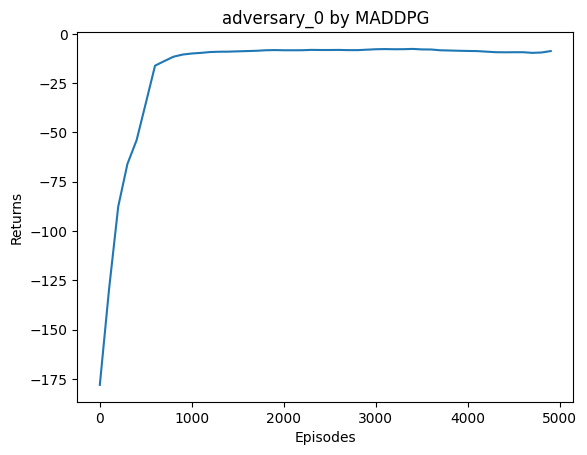

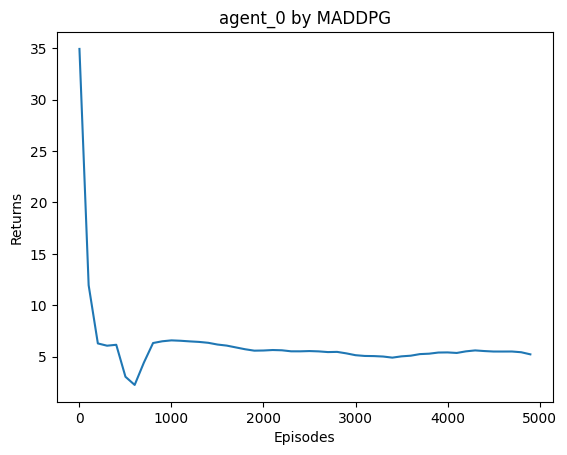

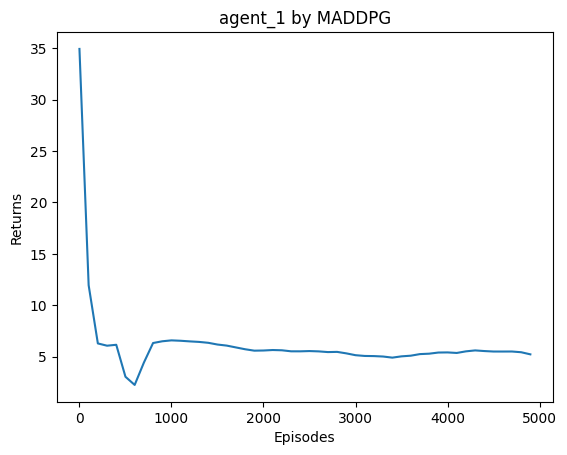

In [13]:
return_array = np.array(return_list)
for i, agent_name in enumerate(["adversary_0", "agent_0", "agent_1"]):
  plt.figure()
  plt.plot(
    np.arange(return_array.shape[0]) * 100,
    rl_utils.moving_average(return_array[:, i], 9)
  )
  plt.xlabel("Episodes")
  plt.ylabel("Returns")
  plt.title(f"{agent_name} by MADDPG")

In [14]:
!pip install --upgrade gym

  Using cached gym-0.26.2-py3-none-any.whl
  Attempting uninstall: gym
    Found existing installation: gym 0.10.5
    Uninstalling gym-0.10.5:
      Successfully uninstalled gym-0.10.5
